In [1]:
from heron import data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
bbh_text = np.genfromtxt("/home/daniel/repositories/heron/data/bbh_mass1_only_hp_3D.txt", delimiter=" ")
bbh_test = np.genfromtxt("/home/daniel/repositories/heron/data/bbh_mass1_only_hp_3D_TEST.txt", delimiter=" ")

In [18]:
bbh = data.Data(bbh_text[:,:3], bbh_text[:,-1],              
                    target_names = ["Times", "Mass", "Spin"],
                    label_names = ["hp strain"],
                    test_size = 0,
                    test_targets = bbh_test[:,:3],
                    test_labels = bbh_test[:,-1]
                    )

In [19]:
bbh_text[1]

array([ -4.60003300e-03,   5.00000000e+00,   0.00000000e+00,
        -7.43371010e-23])

In [5]:
from heron import regression
from heron import kernels

In [6]:
x0 = [(1/np.std(bbh.labels))**2, 50, 10, 10]
gp = regression.Regressor(bbh, kernel=kernels.SquaredExponential(ndim=3), yerror = 1e-23, tikh=1e-6)
gp.set_hyperparameters(x0)

MemoryError: 

In [6]:
x0 = [ 32.57270317,  48.53372059,   5.16764146, ]
#x0 = [0.029974254529549851,  101.2117402 ,    0.84988828]
gp.set_hyperparameters(x0)

ValueError: operands could not be broadcast together with shapes (3,) (1,2) 

In [44]:
x0 = [ 24.95395191,  21.95756258,  -2.07481906, -13.40978644]
#x0 = [0.029974254529549851,  101.2117402 ,    0.84988828]
gp.set_hyperparameters(x0)

1621.3494888554471

In [43]:
100*gp.correlation()

1.0905554982416745

In [8]:
gp.optimise()

/home/daniel/.virtualenvs/heron/local/lib/python2.7/site-packages/heron-0.1.0-py2.7.egg/heron/kernels.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


      fun: -1621.3494842644204
 hess_inv: array([[  9.99812468e-01,   1.37047518e-02,   2.33439320e-03,
         -4.51918736e-03],
       [  1.37047518e-02,   4.73798476e+00,   2.30996089e+00,
         -2.53181884e-01],
       [  2.33439320e-03,   2.30996089e+00,   2.15023437e+00,
         -3.24039211e-01],
       [ -4.51918736e-03,  -2.53181884e-01,  -3.24039211e-01,
          5.71606626e-01]])
      jac: array([ 0.09946597,  8.28764843,  7.00425145, -3.66389638])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 106
      nit: 3
     njev: 94
   status: 2
  success: False
        x: array([ 24.95395191,  21.95756258,  -2.07481906, -13.40978644])

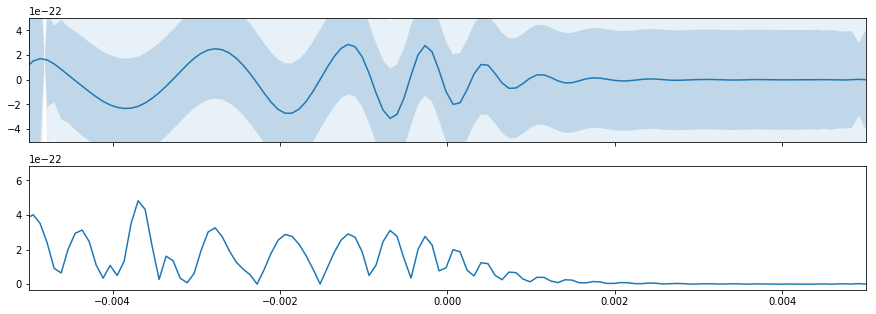

In [45]:
test = np.genfromtxt('/home/daniel/data/imrphenom-test/bbh_mass1_only_hp_test_5d85_S0d25.txt')
f, ax = plt.subplots(2,1, sharey=False, sharex=True, figsize=(15,5))
test_point = 0
t = np.linspace(-0.02,0.005,300)
new_point = np.zeros((300,3))
new_point[:,1] = 5.85
new_point[:,2] = 0.25
new_point[:,0] = t
pred = gp.prediction(new_point)
ax[0].plot(t, pred[0])
ax[0].set_ylim([-.5e-21, .5e-21])
ax[0].set_xlim([-0.005, 0.005])
err = np.diag(pred[1])
err2 = err*1.96
ax[0].fill_between(t, pred[0] - err, pred[0] + err , alpha = 0.2)
ax[0].fill_between(t, pred[0] - err2, pred[0] + err2 , alpha = 0.1)
d = test.T[0][1] - test.T[0][0]
#ax[0].plot(test.T[0]+d, test.T[2])
ax[1].plot(t, np.sqrt((test.T[2] - pred[0])**2))

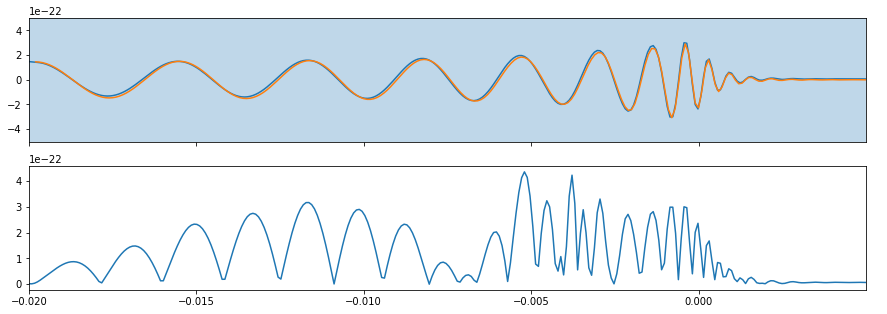

In [13]:
test = np.genfromtxt('/home/daniel/data/imrphenom-test/bbh_mass1_only_hp_test_5d20.txt')
f, ax = plt.subplots(2,1, sharey=False, sharex=True, figsize=(15,5))

t = np.linspace(-0.02,0.005,300)
new_point = np.zeros((300,2))
new_point[:,1] = 5.20
new_point[:,0] = t
pred = gp.prediction(new_point)
ax[0].plot(t, pred[0])
ax[0].set_ylim([-.5e-21, .5e-21])
ax[0].set_xlim([-0.02, 0.005])
err = np.diag(pred[1])
err2 = err*1.96
ax[0].fill_between(t, pred[0] - err, pred[0] + err , alpha = 0.2)
ax[0].fill_between(t, pred[0] - err2, pred[0] + err2 , alpha = 0.1)
d = test.T[0][1] - test.T[0][0]
ax[0].plot(test.T[0]+d, test.T[2])
ax[1].plot(t, np.sqrt((test.T[2] - pred[0])**2))

In [14]:
from heron import acquisition

In [11]:
x0 = [0, 9.5]
gp.expected_improvement(x0)

array([[ -8.87879249e-23]])

In [12]:
from scipy.optimize import minimize

In [18]:
gp.nei([-0.115, 6.7])

array([[ -3.15476884e-19]])

In [7]:
t = np.linspace(-0.02,0.001,300)
new_point = np.zeros((300,2))
new_point[:,1] = 5.20
new_point[:,0] = t

In [10]:
EI = map(gp.expected_improvement, new_point)

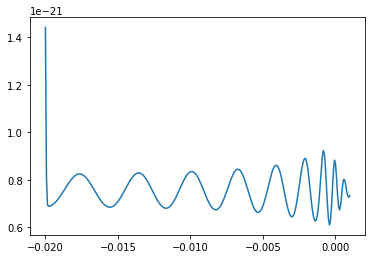

In [29]:
plt.plot(t, EI)

In [28]:
from scipy.optimize import minimize
x0 = [-0.0, 5]
minimize(gp.nei, x0, method='nelder-mead',)

 final_simplex: (array([[ -3.64936543e-05,   5.20756738e+00],
       [ -3.62946399e-05,   5.20762955e+00],
       [ -3.61544282e-05,   5.20759848e+00]]), array([ -8.85746891e-22,  -8.85746800e-22,  -8.85746503e-22]))
           fun: -8.8574689085637502e-22
       message: 'Optimization terminated successfully.'
          nfev: 52
           nit: 27
        status: 0
       success: True
             x: array([ -3.64936543e-05,   5.20756738e+00])

In [23]:
gp.prediction(np.atleast_2d(x0))

(array([ -3.66083102e-22]), array([[  7.90324375e-19]]))

In [31]:
gp.expected_improvement([-0.015, 5.6])

0.0

In [32]:
y_min = gp.training_y.min()

In [36]:
x0 = [0, 9.5]
p, S = gp.prediction(np.atleast_2d(x0))

In [37]:
EI_one = ((y_min - p) * (0.5 + 0.5*m.erf((
          1./np.sqrt(2.))*((y_min - p) /
                           S))))
EI_two = ((S * (1. / np.sqrt(2. * np.pi))) * (np.exp(-(1./2.) *
                                                     ((y_min - p)**2. / S**2.))))
EI = EI_one + EI_two

In [38]:
EI

array([[ -8.87879249e-23]])

In [39]:
S

array([[ -3.66082381e-22]])